# IMPORT PACKAGES

In [8]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/MSc_project/.MAIN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/MSc_project/.MAIN


In [9]:
import pandas as pd 
import pickle
import json
import os
import os.path
import numpy as np
import seaborn as sns
from collections import defaultdict
import joblib
import matplotlib.pyplot as plt
from matplotlib.ticker import (
                               FormatStrFormatter, 
                               AutoMinorLocator,
                               FuncFormatter,
                               )
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
%matplotlib inline
from scipy.spatial import distance
import math

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import os
# os.chdir('G:\My Drive\MSc_project\.MAIN')


In [10]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
        print('F1 score = {:.3e}'.format(tp/(tp + 0.5*(fp+fn))))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

# USER + TWEET FEATURES PREDICTION



length of data
142515
Num of Infectors in Training: 14063 
Num of informers in Training: 85697 


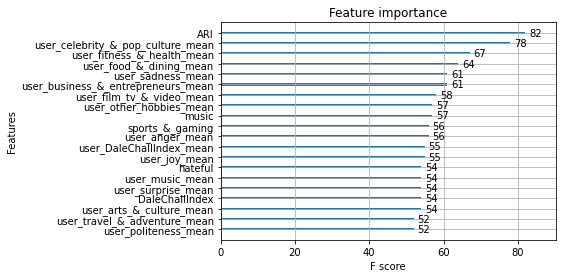

<Figure size 2880x5040 with 0 Axes>

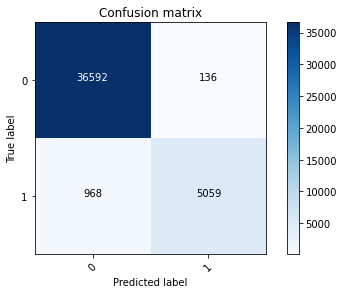

Precision =     0.974
Recall (TPR) =  0.839
Fallout (FPR) = 3.703e-03
F1 score = 9.016e-01
FINISHED PREDICTION FOR UkraineWar





In [16]:
hashtags = ['avengers','blm','brexit','climatechange','covid','gaza','loveisland','monkeypox','nhs','olivianewtonjohn','supercup','UkraineWar']

for h_i,hashtag in enumerate(hashtags):

    df = pd.read_csv(f'multisource_analysis/user_ft_data/{hashtag}_scored_tweets2.csv')
    df.drop(['Unnamed: 0','hashtag','user_id','text_len','text_word_count'], inplace = True, axis =1)
    # df.drop(['Unnamed: 0','hashtag','user_id','target'], inplace = True, axis =1)

    if h_i == 0:
        all_df = df.copy()
    else:   
        all_df = pd.concat( [all_df, df ], axis = 0 )

df = all_df.copy()

fector_df = df.copy()[df['is-infector']==1]
fector_df.set_index('target',inplace=True)
targ_df = df.copy()[df['is-target']==1]
targ_df.set_index('target',inplace=True)
t_cols = df.columns.tolist()
t_cols = [x for x in t_cols if 'user' not in x]
t_cols = [x for x in t_cols if x not in ['is-target','is-infector','is-informer','num_male','num_female','text','target'] ]

u_cols = df.columns.tolist()
u_cols = [ x for x in u_cols if 'user' in x] 
u_cols = u_cols + ['num_male','num_female']
u_cols = [x for x in u_cols if 'count' not in x]

cols = u_cols+t_cols

infector_df = pd.concat( [targ_df.copy()[t_cols],fector_df.copy()[u_cols] ], axis=1   )
infector_df = infector_df.copy().sample(frac=1)


informer_df = df[df['is-informer']==1][cols]
informer_df = informer_df.copy().sample(frac=1)

infector_df['label'] = [1]*len(infector_df)
informer_df['label'] = [0]*len(informer_df)

n1 = int(len(infector_df)*0.7)
n2 = int(len(informer_df)*0.7)

data = pd.concat( [ infector_df.copy().iloc[0:n1], informer_df.copy().iloc[0:n2] ], axis =0)
data = data.sample(frac=1)

data['sentiment'].replace('neutral', 0, inplace = True)
data['sentiment'].replace('negative', 1, inplace = True)
data['sentiment'].replace('positive', 2, inplace = True)
data['user_sentiment_mode'].replace('neutral', 0, inplace = True)
data['user_sentiment_mode'].replace('negative', 1, inplace = True)
data['user_sentiment_mode'].replace('positive', 2, inplace = True)

### TESTING SET

holdout_data = pd.concat( [ infector_df.copy().iloc[n1:],informer_df.copy().iloc[n2:] ], axis =0)
holdout_data = holdout_data.sample(frac=1)

holdout_data['sentiment'].replace('neutral', 0, inplace = True)
holdout_data['sentiment'].replace('negative', 1, inplace = True)
holdout_data['sentiment'].replace('positive', 2, inplace = True)
holdout_data['user_sentiment_mode'].replace('neutral', 0, inplace = True)
holdout_data['user_sentiment_mode'].replace('negative', 1, inplace = True)
holdout_data['user_sentiment_mode'].replace('positive', 2, inplace = True)

print('length of data')
print((len(data)+len(holdout_data)))

X = data[cols]
labels = data['label'].tolist()

num_fector = len( data[data['label']==1] )
num_informer = len( data[data['label']==0] )

print(f'Num of Infectors in Training: { num_fector } ')
print(f'Num of informers in Training: { num_informer } ')

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=2,shuffle=True)

# model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# {'learning_rate': 0.3, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight': 1, 'max_delta_step': 0, 'subsample': 0.8}

model = XGBClassifier(use_label_encoder=False, learning_rate=0.3, n_estimators =  100, objective = 'binary:logistic', max_depth = 6, min_child_weight = 1, max_delta_step = 0, subsample = 0.8)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

import xgboost as xgb
xgb.plot_importance(model, max_num_features=20)
plt.figure(figsize = (40, 70))
# plt.savefig('diss_figs/historic_tweet_featurs.png', facecolor='w')
plt.show()


X_test = holdout_data[cols]
y_test = holdout_data['label']

y_pred = model.predict(X_test)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

del data
del holdout_data
del df
del model
del y_test
del y_pred

print(f'FINISHED PREDICTION FOR {hashtag}\n\n\n')


# TWEET PREDICTION PER HASHTAG

length of data
274541


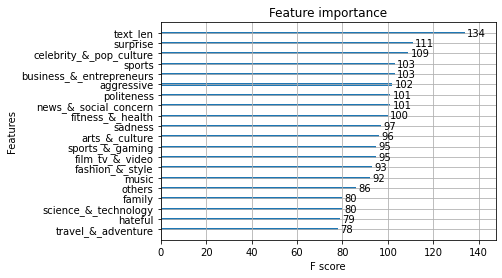

<Figure size 2880x5040 with 0 Axes>

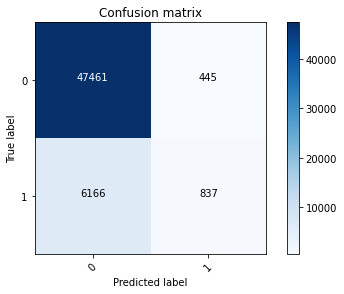

Precision =     0.653
Recall (TPR) =  0.120
Fallout (FPR) = 9.289e-03
F1 score = 2.021e-01
FINISHED PREDICTION FOR TWEETS 





In [25]:
hashtags = ['avengers','blm','brexit','climatechange','covid','gaza','loveisland','monkeypox','nhs','olivianewtonjohn','supercup','UkraineWar']

hashtags = ['avengers','borisjohnson','blm','brexit','climatechange','covid','gaza','loveisland','monkeypox','nhs','olivianewtonjohn','supercup','UkraineWar']

for h_i,hashtag in enumerate(hashtags):

    df = pd.read_csv(f'multisource_analysis/data/{hashtag}_scored_tweets.csv')
    df.drop(['Unnamed: 0','hashtag','user_id'], inplace = True, axis =1)

    if h_i == 0:
        all_df = df.copy()
    else:   
        all_df = pd.concat( [all_df, df ], axis = 0 )

df = all_df.copy()

df.drop(['gender'], inplace = True, axis =1)
# df.drop(['Unnamed: 0','hashtag','user_id','target'], inplace = True, axis =1)

fector_df = df.copy()[df['is-infector']==1]
fector_df.set_index('target',inplace=True)
targ_df = df.copy()[df['is-target']==1]
targ_df.set_index('target',inplace=True)
t_cols = df.columns.tolist()
t_cols = [x for x in t_cols if 'user' not in x]
t_cols = [x for x in t_cols if x not in ['is-target','is-infector','is-informer','num_male','num_female','text','target'] ]

cols = t_cols

infector_df = targ_df.copy()[cols]
infector_df = infector_df.copy().sample(frac=1)

informer_df = df.copy()[df['is-informer']==1][cols]
informer_df = informer_df.copy().sample(frac=1)

infector_df['label'] = [int(1)]*len(infector_df)
informer_df['label'] = [int(0)]*len(informer_df)

n1 = int(len(infector_df)*0.8)
n2 = int(len(informer_df)*0.8)

data = pd.concat( [ infector_df.copy().iloc[0:n1], informer_df.copy().iloc[0:n2] ], axis =0)
data = data.sample(frac=1)

data['sentiment'].replace('neutral', 0, inplace = True)
data['sentiment'].replace('negative', 1, inplace = True)
data['sentiment'].replace('positive', 2, inplace = True)

### TESTING SET

holdout_data = pd.concat( [ infector_df.copy().iloc[n1:],informer_df.copy().iloc[n2:] ], axis = 0)
holdout_data = holdout_data.sample(frac=1)

holdout_data['sentiment'].replace('neutral', 0, inplace = True)
holdout_data['sentiment'].replace('negative', 1, inplace = True)
holdout_data['sentiment'].replace('positive', 2, inplace = True)

print('length of data')
print((len(data)+len(holdout_data)))

X = data[cols]
labels = data['label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=2,shuffle=True)

# model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# {'learning_rate': 0.3, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight': 1, 'max_delta_step': 0, 'subsample': 0.8}

model = XGBClassifier(use_label_encoder=False, learning_rate=0.3, n_estimators =  100, objective = 'binary:logistic', max_depth = 6, min_child_weight = 1, max_delta_step = 0, subsample = 0.8)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

import xgboost as xgb
xgb.plot_importance(model, max_num_features=20)
plt.figure(figsize = (40, 70))
# plt.savefig('diss_figs/historic_tweet_featurs.png', facecolor='w')
plt.show()

X_test = holdout_data[cols]
y_test = holdout_data['label']

y_pred = model.predict(X_test)
# thresh = 0.08
# y_pred [y_pred > thresh] = 1
# y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

print(f'FINISHED PREDICTION FOR TWEETS \n\n\n')


In [32]:
print(len([x for x in y_pred if x==1]))

1282


# USER FEATURES

length of data
142515
Num of Infectors in Training: 14063 
Num of informers in Training: 85697 


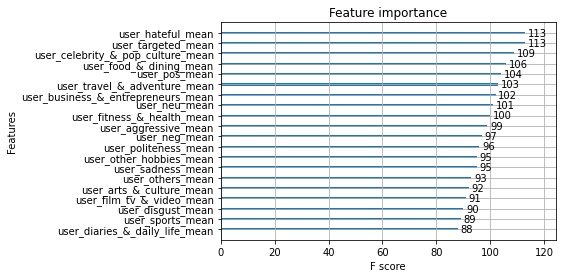

<Figure size 2880x5040 with 0 Axes>

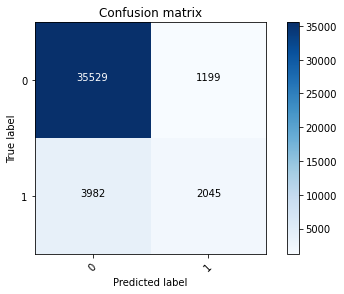

Precision =     0.630
Recall (TPR) =  0.339
Fallout (FPR) = 3.265e-02
F1 score = 4.412e-01
FINISHED PREDICTION FOR UkraineWar





In [19]:
hashtags = ['avengers','blm','brexit','climatechange','covid','gaza','loveisland','monkeypox','nhs','olivianewtonjohn','supercup','UkraineWar']

for h_i,hashtag in enumerate(hashtags):

    df = pd.read_csv(f'multisource_analysis/user_ft_data/{hashtag}_scored_tweets2.csv')
    df.drop(['Unnamed: 0','hashtag','user_id','target'], inplace = True, axis =1)

    if h_i == 0:
        all_df = df.copy()
    else:   
        all_df = pd.concat( [all_df, df ], axis = 0 )

df = all_df.copy()

fector_df = df.copy()[df['is-infector']==1]
fector_df.set_index('target',inplace=True)


u_cols = df.columns.tolist()
u_cols = [ x for x in u_cols if 'user' in x] 
u_cols = u_cols + ['num_male','num_female']
u_cols = [x for x in u_cols if 'count' not in x]

cols = u_cols

infector_df = fector_df.copy()[cols]
infector_df = infector_df.copy().sample(frac=1)

informer_df = df[df['is-informer']==1][cols]
informer_df = informer_df.copy().sample(frac=1)

infector_df['label'] = [1]*len(infector_df)
informer_df['label'] = [0]*len(informer_df)

n1 = int(len(infector_df)*0.7)
n2 = int(len(informer_df)*0.7)

data = pd.concat( [ infector_df.copy().iloc[0:n1], informer_df.copy().iloc[0:n2] ], axis =0)
data = data.sample(frac=1)

data['user_sentiment_mode'].replace('neutral', 0, inplace = True)
data['user_sentiment_mode'].replace('negative', 1, inplace = True)
data['user_sentiment_mode'].replace('positive', 2, inplace = True)

### TESTING SET

holdout_data = pd.concat( [ infector_df.copy().iloc[n1:],informer_df.copy().iloc[n2:] ], axis =0)
holdout_data = holdout_data.sample(frac=1)

holdout_data['user_sentiment_mode'].replace('neutral', 0, inplace = True)
holdout_data['user_sentiment_mode'].replace('negative', 1, inplace = True)
holdout_data['user_sentiment_mode'].replace('positive', 2, inplace = True)

print('length of data')
print((len(data)+len(holdout_data)))

X = data[cols]
labels = data['label'].tolist()

num_fector = len( data[data['label']==1] )
num_informer = len( data[data['label']==0] )

print(f'Num of Infectors in Training: { num_fector } ')
print(f'Num of informers in Training: { num_informer } ')

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=2,shuffle=True)

# model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# {'learning_rate': 0.3, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight': 1, 'max_delta_step': 0, 'subsample': 0.8}

model = XGBClassifier(use_label_encoder=False, learning_rate=0.3, n_estimators =  100, objective = 'binary:logistic', max_depth = 6, min_child_weight = 1, max_delta_step = 0, subsample = 0.8)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

import xgboost as xgb
xgb.plot_importance(model, max_num_features=20)
plt.figure(figsize = (40, 70))
# plt.savefig('diss_figs/historic_tweet_featurs.png', facecolor='w')
plt.show()


X_test = holdout_data[cols]
y_test = holdout_data['label']

y_pred = model.predict(X_test)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

del data
del holdout_data
del df
del model
del y_pred
del y_test

print(f'FINISHED PREDICTION FOR {hashtag}\n\n\n')


# 10 FEED USER + TWEET SCORES

length of data
142515
Num of Infectors in Training: 14063 
Num of informers in Training: 85697 


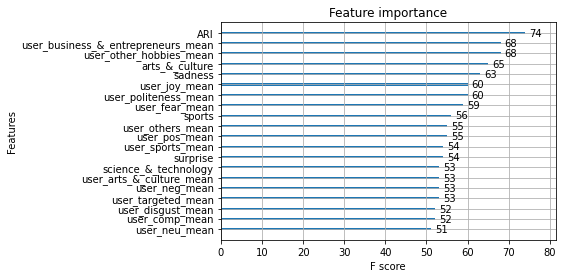

<Figure size 2880x5040 with 0 Axes>

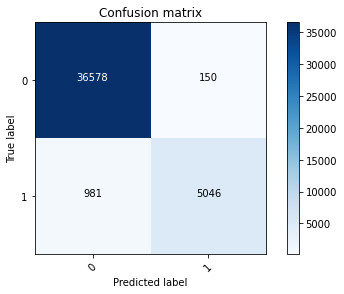

Precision =     0.971
Recall (TPR) =  0.837
Fallout (FPR) = 4.084e-03
F1 score = 8.992e-01
FINISHED PREDICTION FOR UkraineWar





In [45]:
hashtags = ['avengers','blm','brexit','climatechange','covid','gaza','loveisland','monkeypox','nhs','olivianewtonjohn','supercup','UkraineWar']

for h_i,hashtag in enumerate(hashtags):

    df = pd.read_csv(f'multisource_analysis/user_ft_data/{hashtag}_scored_tweets_10_feeds.csv')
    df.drop(['Unnamed: 0','hashtag','user_id','text_len','text_word_count'], inplace = True, axis =1)
    # df.drop(['Unnamed: 0','hashtag','user_id','target'], inplace = True, axis =1)

    if h_i == 0:
        all_df = df.copy()
    else:   
        all_df = pd.concat( [all_df, df ], axis = 0 )

df = all_df.copy()

fector_df = df.copy()[df['is-infector']==1]
fector_df.set_index('target',inplace=True)
targ_df = df.copy()[df['is-target']==1]
targ_df.set_index('target',inplace=True)
t_cols = df.columns.tolist()
t_cols = [x for x in t_cols if 'user' not in x]
t_cols = [x for x in t_cols if x not in ['is-target','is-infector','is-informer','num_male','num_female','text','target'] ]

u_cols = df.columns.tolist()
u_cols = [ x for x in u_cols if 'user' in x] 
u_cols = u_cols + ['num_male','num_female']
u_cols = [x for x in u_cols if 'count' not in x]

cols = u_cols+t_cols

infector_df = pd.concat( [targ_df.copy()[t_cols],fector_df.copy()[u_cols] ], axis=1   )
infector_df = infector_df.copy().sample(frac=1)


informer_df = df[df['is-informer']==1][cols]
informer_df = informer_df.copy().sample(frac=1)

infector_df['label'] = [1]*len(infector_df)
informer_df['label'] = [0]*len(informer_df)

n1 = int(len(infector_df)*0.7)
n2 = int(len(informer_df)*0.7)

data = pd.concat( [ infector_df.copy().iloc[0:n1], informer_df.copy().iloc[0:n2] ], axis =0)
data = data.sample(frac=1)

data['sentiment'].replace('neutral', 0, inplace = True)
data['sentiment'].replace('negative', 1, inplace = True)
data['sentiment'].replace('positive', 2, inplace = True)
data['user_sentiment_mode'].replace('neutral', 0, inplace = True)
data['user_sentiment_mode'].replace('negative', 1, inplace = True)
data['user_sentiment_mode'].replace('positive', 2, inplace = True)

### TESTING SET

holdout_data = pd.concat( [ infector_df.copy().iloc[n1:],informer_df.copy().iloc[n2:] ], axis =0)
holdout_data = holdout_data.sample(frac=1)

holdout_data['sentiment'].replace('neutral', 0, inplace = True)
holdout_data['sentiment'].replace('negative', 1, inplace = True)
holdout_data['sentiment'].replace('positive', 2, inplace = True)
holdout_data['user_sentiment_mode'].replace('neutral', 0, inplace = True)
holdout_data['user_sentiment_mode'].replace('negative', 1, inplace = True)
holdout_data['user_sentiment_mode'].replace('positive', 2, inplace = True)

print('length of data')
print((len(data)+len(holdout_data)))

X = data[cols]
labels = data['label'].tolist()

num_fector = len( data[data['label']==1] )
num_informer = len( data[data['label']==0] )

print(f'Num of Infectors in Training: { num_fector } ')
print(f'Num of informers in Training: { num_informer } ')

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=2,shuffle=True)

# model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# {'learning_rate': 0.3, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight': 1, 'max_delta_step': 0, 'subsample': 0.8}

model = XGBClassifier(use_label_encoder=False, learning_rate=0.3, n_estimators =  100, objective = 'binary:logistic', max_depth = 6, min_child_weight = 1, max_delta_step = 0, subsample = 0.8)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

import xgboost as xgb
xgb.plot_importance(model, max_num_features=20)
plt.figure(figsize = (40, 70))
# plt.savefig('diss_figs/historic_tweet_featurs.png', facecolor='w')
plt.show()


X_test = holdout_data[cols]
y_test = holdout_data['label']

y_pred = model.predict(X_test)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

del data
del holdout_data
del df
del model
del y_test
del y_pred

print(f'FINISHED PREDICTION FOR {hashtag}\n\n\n')


# USER FEATURE DIFFERENCES

In [ ]:
hashtags = ['avengers','blm','brexit','climatechange','covid','gaza','loveisland','monkeypox','nhs','olivianewtonjohn','supercup','UkraineWar']

for h_i,hashtag in enumerate(hashtags):

    df = pd.read_csv(f'multisource_analysis/user_ft_data/{hashtag}_scored_tweets2.csv')
    df.drop(['Unnamed: 0','hashtag','user_id','target'], inplace = True, axis =1)

    if h_i == 0:
        all_df = df.copy()
    else:   
        all_df = pd.concat( [all_df, df ], axis = 0 )

df = all_df.copy()

fector_df = df.copy()[df['is-infector']==1]
fector_df.set_index('target',inplace=True)


u_cols = df.columns.tolist()
u_cols = [ x for x in u_cols if 'user' in x] 
u_cols = u_cols + ['num_male','num_female']
u_cols = [x for x in u_cols if 'count' not in x]

cols = u_cols

infector_df = fector_df.copy()[cols]

infector_df = infector_df.copy().sample(frac=1)

informer_df = df[df['is-informer']==1][cols]
informer_df = informer_df.copy().sample(frac=1)

infector_df['label'] = [1]*len(infector_df)
informer_df['label'] = [0]*len(informer_df)

n1 = int(len(infector_df)*0.7)
n2 = int(len(informer_df)*0.7)

data = pd.concat( [ infector_df.copy().iloc[0:n1], informer_df.copy().iloc[0:n2] ], axis =0)
data = data.sample(frac=1)

data['user_sentiment_mode'].replace('neutral', 0, inplace = True)
data['user_sentiment_mode'].replace('negative', 1, inplace = True)
data['user_sentiment_mode'].replace('positive', 2, inplace = True)

### TESTING SET

holdout_data = pd.concat( [ infector_df.copy().iloc[n1:],informer_df.copy().iloc[n2:] ], axis =0)
holdout_data = holdout_data.sample(frac=1)

holdout_data['user_sentiment_mode'].replace('neutral', 0, inplace = True)
holdout_data['user_sentiment_mode'].replace('negative', 1, inplace = True)
holdout_data['user_sentiment_mode'].replace('positive', 2, inplace = True)

print('length of data')
print((len(data)+len(holdout_data)))

X = data[cols]
labels = data['label'].tolist()

num_fector = len( data[data['label']==1] )
num_informer = len( data[data['label']==0] )

print(f'Num of Infectors in Training: { num_fector } ')
print(f'Num of informers in Training: { num_informer } ')

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=2,shuffle=True)

# model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# {'learning_rate': 0.3, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight': 1, 'max_delta_step': 0, 'subsample': 0.8}

model = XGBClassifier(use_label_encoder=False, learning_rate=0.3, n_estimators =  100, objective = 'binary:logistic', max_depth = 6, min_child_weight = 1, max_delta_step = 0, subsample = 0.8)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

import xgboost as xgb
xgb.plot_importance(model, max_num_features=20)
plt.figure(figsize = (40, 70))
# plt.savefig('diss_figs/historic_tweet_featurs.png', facecolor='w')
plt.show()


X_test = holdout_data[cols]
y_test = holdout_data['label']

y_pred = model.predict(X_test)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

del data
del holdout_data
del df
del model
del y_pred
del y_test

print(f'FINISHED PREDICTION FOR {hashtag}\n\n\n')
